In [11]:
import pandas as pd
import numpy as np
import pickle, re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, dendrogram, leaves_list, fcluster
import seaborn as sns
from os.path import join
from os import path

channels = ["DNA", "RNA", "AGP", "ER", "Mito"]

experiment_code = 'avg'
dataset = 37
neg_control = 'DMSO@0' if dataset == 22 else 'EMPTY_'

wells = {ch: pd.read_csv(join(f"BBBC0{dataset}", "features", f"{experiment_code}_{ch}_well.csv")) for ch in channels}
wells['base'] = pd.read_csv(join(f"BBBC0{dataset}", "features", "B0_1_well.csv"))
f_cols = wells['base'].columns[5:]

# CellProfiler features
cp = pd.read_csv(f'../activation_layers/BBBC0{dataset}/features/cp_BBBC0{dataset}_augmented.csv')
cp = cp[[c for c in cp.columns if 'Metadata' not in c]]
cp = cp.dropna(axis=1)

# Grupirane CP značilke
lokalizacija_objekta = [c for c in cp.columns if 'Center' in c or 'Count' in c]
povrsina_oblika = [c for c in cp if re.match(r".*_Area$", c) or any(['Perimeter' in c, 'Axis' in c, 'Eccentricity' in c, 'Solidity' in c, 'Extent' in c, 'EulerNumber' in c])]
intenzitete = [c for c in cp if '_Intensity_' in c]
tekstura = [c for c in cp if any(['Angular' in c, 'Contrast' in c])]
sosedi = [c for c in cp if 'NumberOfNeighbors' in c]
korelacija = [c for c in cp if '_Correlation_' in c]
posebne = [c for c in cp if any(['Zernike' in c, 'Gabor' in c])]
cp_groups = [('Tekstura', tekstura), ("Intenziteta", intenzitete), ("Površina in oblika", povrsina_oblika), ('Posebne lastnosti', posebne), ("Lokalizacija objekta", lokalizacija_objekta)]

# Hierarhično gručenje

- Za vsak eksperiment posebej

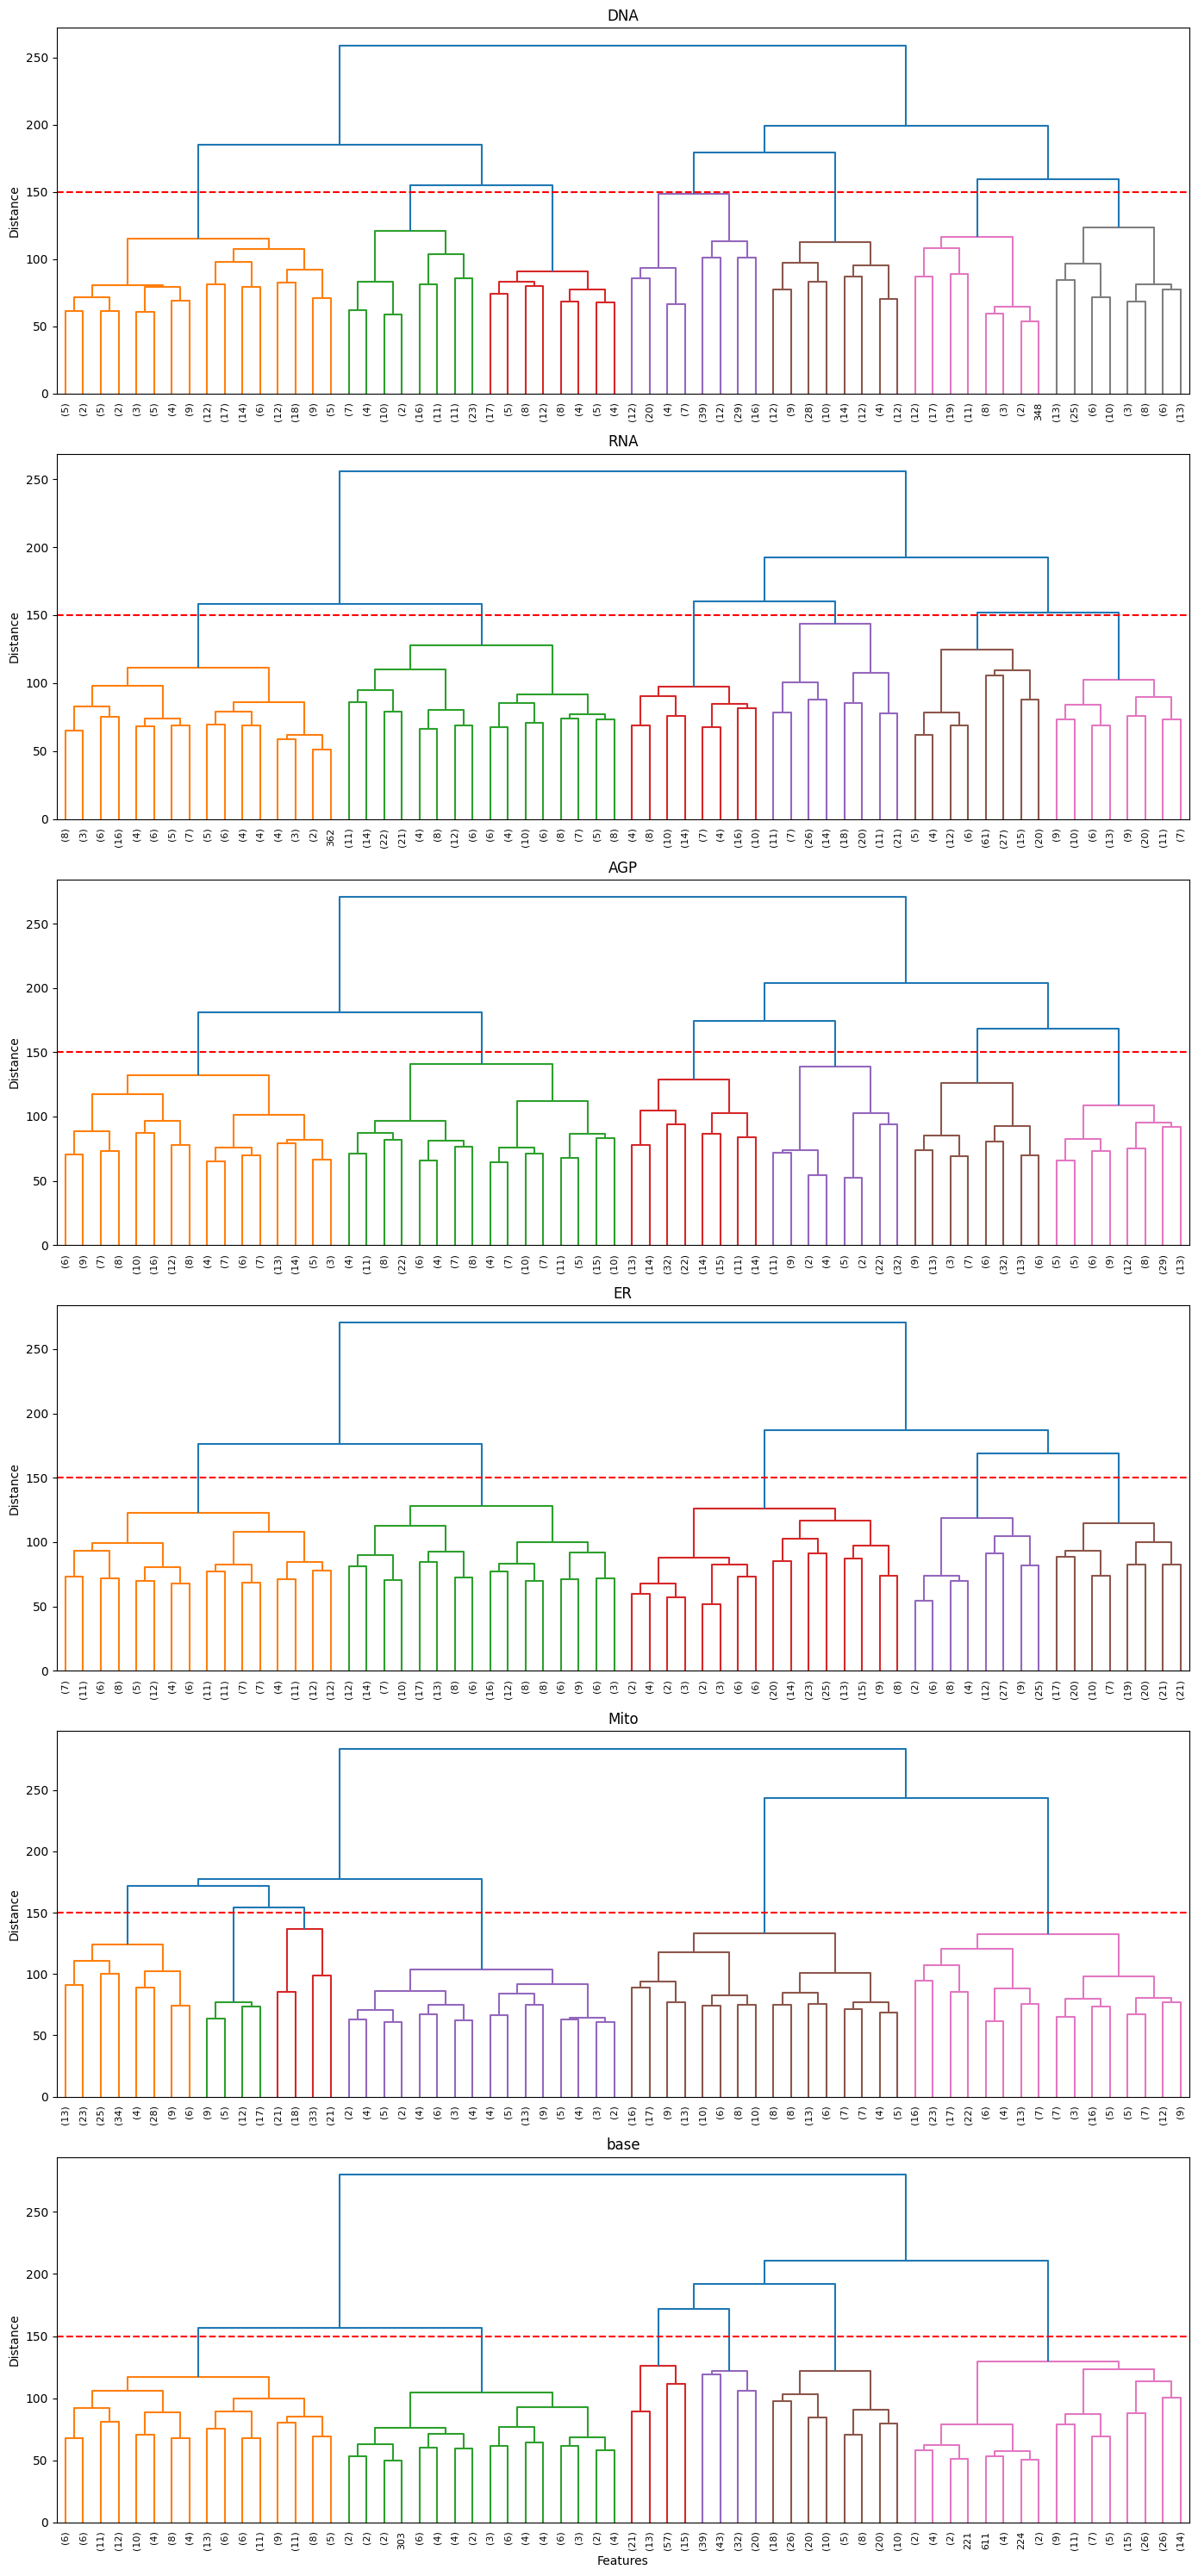

In [2]:
# Ward variance minimization algorithm, minimizira varianco v clustrih
method = 'ward'
metric = 'euclidean'

distance = 150

links = {}
clusters = {}
results = []

for ch, df in wells.items():

    # Skaliram podatke -> Mean ~ 0 in Std ~ 1 za vsak feature
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df[f_cols])
    df_scaled = pd.DataFrame(data_scaled, columns=f_cols)
    df_scaled = df_scaled.transpose()

    # Hierarhično gručenje
    linked = linkage(df_scaled, method=method, metric=metric, optimal_ordering=True)

    df_linked = pd.DataFrame(linked, columns=['c1', 'c2', 'distance', 'size'])
    df_linked[['c1', 'c2', 'size']] = df_linked[['c1', 'c2', 'size']].astype('int')

    # maxclust - Pridobivanje clustrov - maksimalno t clustrov, dendrogram je prerezan na točki/nivoju, ki rezultira v t clustrih
    # clstr = fcluster(linked, t=5, criterion='maxclust')
    
    # distance - Pridobivanje clustrov - clustri, ki so zdruzeni blizje kot t so zdruzeni v en cluster
    # featureji, ki so med sabo oddaljeni vec kot t, so v drugacnih clustrih
    clstr = fcluster(linked, criterion='distance', t=distance)

    clstr_df = pd.DataFrame({'Feature': df_scaled.index, 'Cluster': clstr})
    df_scaled['Cluster'] = clstr

    for c in set(clstr):
        cluster_features = df_scaled[df_scaled.Cluster == c].drop(columns='Cluster')

        # Povprečna varianca featurjev v clustru
        variance = cluster_features.var(axis=1).mean()

        # Korelacija featurjev v clustru
        cluster_corr_matrix = cluster_features.transpose().corr()
        abs_corr = cluster_corr_matrix.where(np.triu(np.ones(cluster_corr_matrix.shape), k=1).astype(bool)).abs().stack()

        results.append({"Experiment": ch,
                    "Cluster": c,
                    "Variance": variance,
                    "Mean Correlation": abs_corr.mean(),
                    "Max Correlation": abs_corr.max(),
                    "Min Correlation": abs_corr.min()})
    
    links[ch] = df_linked
    clusters[ch] = clstr_df

clusters_results = pd.DataFrame(results)

fig, axes = plt.subplots(len(links), 1, figsize=(14, len(links) * 5))
p = 5

for idx, (ch, linked) in enumerate(links.items()):
    dendrogram(linked, ax=axes[idx], leaf_rotation=90, leaf_font_size=8, p=p, truncate_mode='level', color_threshold=distance)
    axes[idx].axhline(y=distance, color='r', linestyle='--')
    axes[idx].set_title(ch)
    if idx == len(links) - 1:
        axes[idx].set_xlabel("Features")
    axes[idx].set_ylabel("Distance")

plt.tight_layout()
plt.show()

In [3]:
results = []

for ch, df_clusters in clusters.items():
    for cluster in df_clusters.Cluster.unique():
        # Vsi featurji v tem clustru
        cluster_features = df_clusters[df_clusters.Cluster == cluster].index.tolist()
        
        # Dataframe: vsi primeri x featurji v clustru
        df = wells[ch][map(str, cluster_features)]

        # Izracunam korelacijo z vsako CP skupino
        for name, cpg in cp_groups:

            # Zdruzim s CP featurji in izracunam korelacijo
            combined = pd.concat([df, cp[cpg]], axis=1)
            correlation_matrix = combined.corr()
            correlation_matrix = correlation_matrix.loc[df.columns, cpg]

            # Vzamem mean
            mean = correlation_matrix.dropna(axis=1).abs().mean().mean()

            results.append({
                "Experiment": ch,
                "Cluster": cluster,
                "CP Skupina": name,
                "Mean Correlation": mean
            })

cp_corr_results = pd.DataFrame(results)

# Clusterji z največjo povprečno korelacijo
cp_corr_results.nlargest(n=20, columns='Mean Correlation')

,Experiment,Cluster,CP Skupina,Mean Correlation
142,Mito,2,Površina in oblika,0.197566
141,Mito,2,Intenziteta,0.186403
62,RNA,6,Površina in oblika,0.170522
82,AGP,2,Površina in oblika,0.152003
140,Mito,2,Tekstura,0.149544
61,RNA,6,Intenziteta,0.149339
172,base,5,Površina in oblika,0.147568
176,base,2,Intenziteta,0.146897
157,base,1,Površina in oblika,0.141940
2,DNA,2,Površina in oblika,0.141808


# Korelacija DP in CP značilk

- Za vsako DP značilko, za vsak eksperiment izračunam korelacijo z vsako CP značilko + CP skupinami

In [4]:
filename = f'features_cp_corr_{dataset}.csv'

if not path.exists(filename):
    results = []
    for feature in f_cols:
        for ch, df in wells.items():
            cp_correlations_abs = cp.corrwith(df[str(feature)]).abs()
            r = {
                "Feature": feature,
                "Experiment": ch,
                "Correlation": cp_correlations_abs.max(),
                "Max Abs Correlated CP": cp_correlations_abs.idxmax(),
            }
            for name, cpg in cp_groups:
                r[name] = cp_correlations_abs[cpg].mean()
            results.append(r)

    pd.DataFrame(results).to_csv(filename, index=False)

# Za vsako DP značilko: Eksperiment z max CP korelacijo + njene korelacije s CP skupinami
features_cp_corr = pd.read_csv(filename)
feature_max_corr = features_cp_corr.loc[features_cp_corr.groupby("Feature")["Correlation"].idxmax()]
feature_max_corr

,Feature,Experiment,Correlation,Max Abs Correlated CP,Tekstura,Intenziteta,Površina in oblika,Posebne lastnosti,Lokalizacija objekta
2,0,AGP,0.436385,Nuclei_Granularity_5_ER,0.121127,0.203557,0.215288,0.132838,0.019336
11,1,base,0.577261,Cytoplasm_Texture_SumAverage_ER_10_0,0.256829,0.144468,0.195628,0.130198,0.049234
16,2,Mito,0.641876,Nuclei_Correlation_Manders_ER_RNA,0.213602,0.098169,0.193846,0.117201,0.048546
21,3,ER,0.432907,Nuclei_RadialDistribution_RadialCV_DNA_2of4,0.093964,0.197212,0.107239,0.092715,0.095479
25,4,RNA,0.480466,Cells_Intensity_StdIntensityEdge_RNA,0.120420,0.205011,0.204315,0.117862,0.044651
...,...,...,...,...,...,...,...,...,...
4002,667,DNA,0.464296,Cells_Intensity_MaxIntensityEdge_AGP,0.144487,0.216275,0.277255,0.169596,0.041293
4013,668,base,0.547813,Cells_AreaShape_FormFactor,0.220810,0.287905,0.275298,0.156495,0.095746
4014,669,DNA,0.435283,Cytoplasm_Texture_InverseDifferenceMoment_RNA_...,0.215777,0.151579,0.182162,0.122741,0.006900
4020,670,DNA,0.505466,Cells_Intensity_MaxIntensityEdge_DNA,0.105080,0.227555,0.239705,0.145093,0.058009


# Hierarhično gručenje

- Za vse eksperimente skupaj
- Optimal Leaf Reordering

In [5]:
# Združimo vse well-level profile vseh eksperimentov + izhodiščni
merged = pd.DataFrame()
for ch, df in wells.items():
    merged = pd.concat([merged, df], axis=0).reset_index(drop=True)

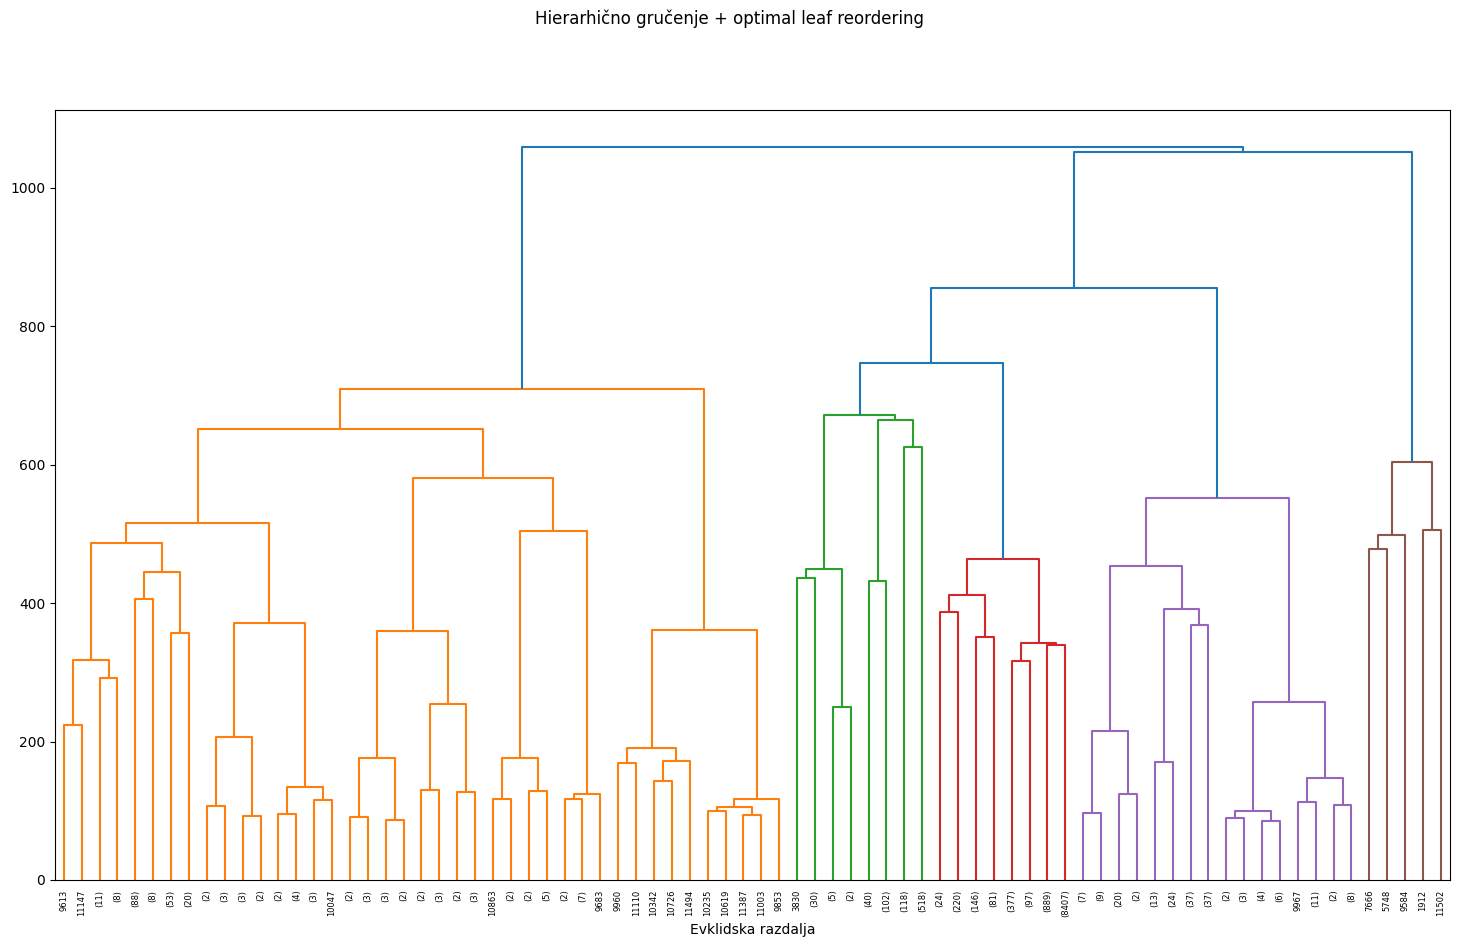

In [10]:
# Hierarhično gručenje + optimal leaf reordering
filename = f'optimal_leaf_ordering_{dataset}.pkl'

if not path.exists(filename):
    linkage_matrix = linkage(merged[f_cols], method='ward', metric='euclidean')
    ordered_linked = optimal_leaf_ordering(linkage_matrix, merged[f_cols], metric='euclidean')

with open(filename, 'rb') as f:
    ordered_linked = pickle.load(f)

plt.figure(figsize=(18, 10))
dendrogram(ordered_linked, p=6, truncate_mode='level')
plt.suptitle('Hierarhično gručenje + optimal leaf reordering')
plt.xlabel('Well-Level profili')
plt.xlabel('Evklidska razdalja')
plt.show()

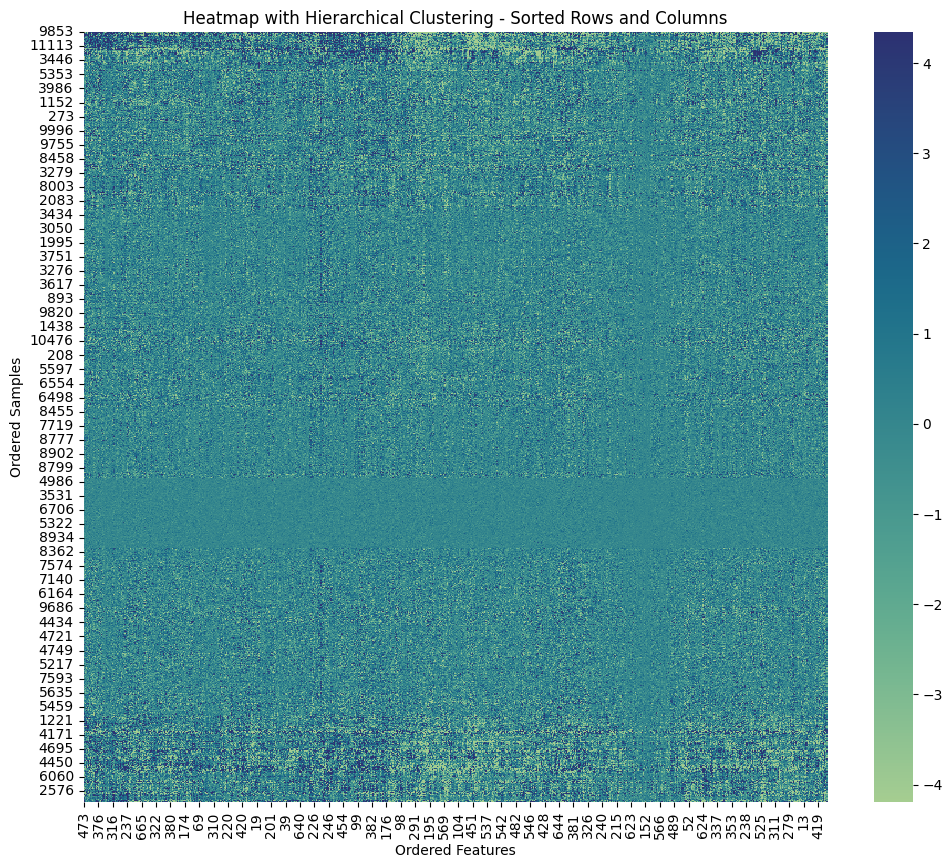

In [9]:
features = merged[f_cols]

# Compute the pairwise distances between rows and columns
row_distances = pdist(features, metric='euclidean')
col_distances = pdist(features.T, metric='euclidean')

# Perform hierarchical clustering for rows and columns separately
row_clusters = linkage(row_distances, method='ward')
col_clusters = linkage(col_distances, method='ward')

# Obtain the order of rows and columns according to the clustering
row_order = leaves_list(row_clusters)
col_order = leaves_list(col_clusters)

# Reorder the DataFrame according to the clustering for rows and columns
ordered_features = features.iloc[row_order, :].iloc[:, col_order]

plt.figure(figsize=(12, 10))
sns.heatmap(ordered_features, cmap='crest', robust=True)
plt.title('Heatmap with Hierarchical Clustering - Sorted Rows and Columns')
plt.xlabel('Ordered Features')
plt.ylabel('Ordered Samples')
plt.show()
